# Import packages

/Users/amirhsi/miniconda3/envs/polylab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


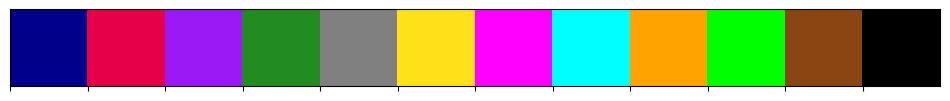

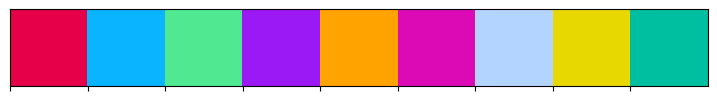

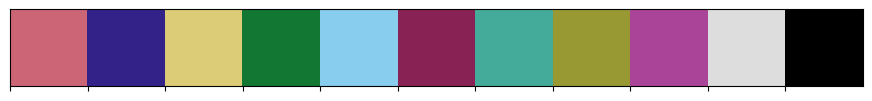

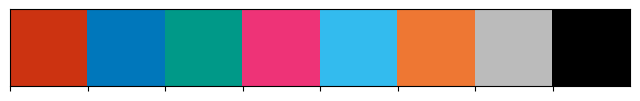

In [1]:
# Importing necessary packages:
from glob import glob
import re
import numpy as np
import pandas as pd
import itertools
from  matplotlib import colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_VIBRANT as PTV
from polyphys.visualize.plotter import SIZE_MEASURES_LABELS as SML

from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.manage import utilizer
from polyphys.manage.parser import (TransFociCub, TransFociCyl, 
                                    SumRuleCubHeteroRing, SumRuleCubHeteroRing)

sns.palplot(AC)
sns.palplot(DF_colors)
sns.palplot(PTM)
sns.palplot(PTV)

import warnings
warnings.filterwarnings("ignore")

# Merge spaces with same $a_l$ but different $a_c$

## Reading and merging equilibrium properties, direct contacts and clusters from different projects

In [8]:
# project = 'SumRuleCubHeteroLinear'
#allInOne_dbs = ['/Users/amirhsi/research_data/SumRuleCubHeteroLinear-allInOne/']#, '../../Datasets/'+project+'-allInOne/']
phase = 'ensAvg'
projects = ['SumRuleCubHeteroLinear', 'SumRuleCubHeteroRing', 'TransFociCub']
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']
measures = ['mean', 'sem', 'var']
geometry_names_full = {
    'TransFociCub':  r'$D=\infty$',
    'SumRuleCubHeteroLinear':  r'$D=\infty$',
    'SumRuleCubHeteroRing':  r'$D=\infty$',
    'TransFociCub-LJ_pow12': r'$D=\infty$ (LJ repulsion only)',
    'TransFociCub-InitialCompressed': r'$D=\infty$ (Chain and crowders equilibrated)',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free Space', 'Free Space-LJ_pow12', 'TransFociCub-InitialCompressed'] # TransFocuCyl added later
foci_list = []
chainsize_trans_foci = []
project_title_style = ''
project_titles = {}
for project in projects:
    print(project)
    allInOne_db = '../../../Datasets/'+project+'-allInOne/'
    projects_comon_title = ''
    # Equilbrium properties
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps',
         phase
        ])
    equil_db = allInOne_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    chainsize_equil['project'] = project
    chainsize_equil['topology'] = PD[project]['topology']
    # phi_c to drop
    if project == 'TransFociCyl':
        chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
    print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
    
    # rho_m in the sphere created by it gyr
    chainsize_equil['rho_m_self'] = \
        (3 * (chainsize_equil['nmon_large'] + chainsize_equil['nmon_small'])) / (4 * np.pi * chainsize_equil['gyrMon-mean'] ** 3)
    # phi_m in the sphere created by it gyr: dmon = 1
    chainsize_equil['phi_m_self'] = \
        (3 * (chainsize_equil['nmon_large'] * np.pi * chainsize_equil['dmon_large'] ** 3 / 6 + chainsize_equil['nmon_small']) * np.pi / 6) / (4 * np.pi * chainsize_equil['gyrMon-mean'] ** 3)
    chainsize_equil.reset_index(inplace=True, drop=True)
    # selecting 'norm' measures of properties
    attributes = PD[project]['equil_attributes'] + \
        ['rho_m_self', 'phi_m_self', 'topology', 'project']
    # globe size line
    if project == 'TransFociCyl':
        dmon_large_cond = (chainsize_equil['dmon_large'] == 5)
        phi_c_cond = (chainsize_equil['phi_c_bulk_round'] == 0)
        gyr_phic0_dmon_large = chainsize_equil.loc[dmon_large_cond & phi_c_cond, 'gyrMon-mean'].values[0]
        nmon_small = chainsize_equil['nmon_small'].values[0]
        nmon_large = chainsize_equil['nmon_large'].values[0]
        globe_size = (nmon_small + nmon_large) ** (1/3)
        r_globe_ratio = globe_size/gyr_phic0_dmon_large
    #norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
    # option 1: norms of asphericityMon-norm and shapeMona
    #selected_cols = attributes + norm_props
    #value_vars = norm_props
    # option 2: means of asphericityMon-norm and shapeMona
    gyr_fsd_only_norm_props = [
        'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
    ]
    selected_cols = attributes + gyr_fsd_only_norm_props
    value_vars = gyr_fsd_only_norm_props
    # melting properties column
    chainsize_melted = chainsize_equil[selected_cols].melt(
        id_vars=attributes,
        value_vars=value_vars,
        var_name='property'
    )
    print(chainsize_melted.isna().sum())
    # dictionary of normalizer properties' features
    spaces = chainsize_melted['space'].unique()
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
    project_titles[project] = project_title_style
    if project == 'TransFociCyl':
        chainsize_melted['geometry'] = chainsize_melted['dcyl'].apply(lambda x: rf"${x}$")
        chainsize_melted['geometry_fullname'] = geometry_names_full[project] + chainsize_melted['dcyl'].apply(lambda x: f" ($D={x}$)")
    else:
        chainsize_melted['geometry'] = r'$\infty$'
        chainsize_melted['geometry_fullname'] = geometry_names_full[project]
    chainsize_trans_foci.append(chainsize_melted)
    
    # Direct contacts and clusters
    for prop in hist_properties:
        print(prop)
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = allInOne_db + hist_df
        hist_df = pd.read_parquet(hist_df)
        hist_df['topology'] = PD[project]['topology']
        hist_df['project'] = project
        if project == 'TransFociCyl':
            hist_df['geometry'] = hist_df['dcyl'].apply(lambda x: rf"${x}$")
            hist_df['geometry_fullname'] = geometry_names_full[project] + hist_df['dcyl'].apply(lambda x: f"$D={x}$")
        else:
            hist_df['geometry'] = r'$\infty$'
            hist_df['geometry_fullname'] = geometry_names_full[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        hist_df.rename(columns={prop + '-norm': 'probability'}, inplace=True)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
            style = TS[project]
            cond = hist_df['space']==space
            hist_df.loc[cond,'space_title'] = style['title'](s_info)
            hist_df.loc[cond,'space_title_short'] = style['short'](s_info)
            hist_df.loc[cond,'universe'] = style['universe'](s_info)
            
            if s_info.dmon_large == 5.0:
                projects_comon_title = (
                    fr"$N_m={s_info.nmon_small},$ " +
                    fr"$N_M={s_info.nmon_large},$ " +
                    fr"$a_c={s_info.dcrowd}$"
                )
        project_titles[project] = projects_comon_title 
        print(hist_df.isna().sum())
        foci_list.append(hist_df)


chainsize_trans_foci = pd.concat(chainsize_trans_foci, axis=0)
chainsize_trans_foci.reset_index(inplace=True, drop=True)
chainsize_trans_foci.drop(columns=['space', 'ensemble', 'phi_c_bulk'], inplace=True)

# For free space dcyl=0
#chainsize_trans_foci['dcyl'].fillna(value=0, inplace=True) # this is when studies TransFociCyl
# For all project
chainsize_trans_foci['dcyl'] = 0 # This is for when studying TrasFociCub alone


foci = pd.concat(foci_list, axis=0)
foci.reset_index(inplace=True, drop=True)
print(foci.columns)
# For free space dcyl=0
#foci['dcyl'].fillna(value=0, inplace=True) # this is when studies TransFociCyl
# For all project
foci['dcyl'] = 0 # This is for when studying TrasFociCub alone
foci.drop(columns=['bin_center-norm', 'space', 'ensemble', 'phi_c_bulk'], inplace=True)
print('columns:' , foci.columns)
# cdfs

foci_grouped = foci.groupby(['dmon_large', 'dcrowd', 'phi_c_bulk_round', 'geometry', 'property', 'topology', 'project'])

# Function to calculate the cumulative distribution function
def calculate_cdf(group):
    # Sort by the 'bin_center' to ensure proper CDF calculation
    group = group.sort_values(by='bin_center')
    # Calculate the cumulative sum of probabilities
    group['cdf'] = group['probability'].cumsum()
    return group

# Apply the function to each group and calculate CDF for each 'property'
foci_cdf = foci_grouped.apply(calculate_cdf)
foci_cdf.reset_index(drop=True, inplace=True)


# Weighed average of cluster size and direct contact:
gb_cols = ['dmon_large', 'phi_c_bulk_round', 'geometry', 'geometry_fullname','property', 'dcrowd', 'nmon_large', 'nmon_small', 'dcyl', 'ensemble_long', 'topology', 'project']
foci_weighted = foci.groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability']).sum() / x['probability'].sum())
# give the result a meaningful name
foci_weighted = foci_weighted.rename("bin_center-average").reset_index()
foci_weighted.rename(
    columns={'bin_center-average': 'value'},
    inplace=True
    )

#chainsize_trans_foci.to_csv("../../Datasets/TransFoci-allInOne_InitialCompressed-phi_m_self-rho_m_self-ensAvg.csv", index=False)
# cubic geometry does not have 'dcyl' values, so fill it with 0
chainsize_trans_foci.fillna(0, inplace=True)
# merge cluster info with chain size info:
equi_props = pd.concat([chainsize_trans_foci, foci_weighted])
print(equi_props.columns)

SumRuleCubHeteroLinear
unique phi_c_bulk: [0.0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
ensemble_long       0
ensemble            0
space               0
dmon_large          0
nmon_large          0
nmon_small          0
dcrowd              0
phi_c_bulk          0
phi_c_bulk_round    0
rho_m_self          0
phi_m_self          0
topology            0
project             0
property            0
value               0
dtype: int64
clustersHistFoci
bin_center           0
bin_center-norm      0
probability          0
space                0
ensemble_long        0
ensemble             0
nmon_small           0
nmon_large           0
dmon_large           0
dcrowd               0
phi_c_bulk           0
phi_c_bulk_round     0
topology             0
project              0
geometry             0
geometry_fullname    0
property             0
space_title          0
space_title_short    0
universe             0
dtype: int64
bondsHistFoci
bin_center           0
bin_center-norm 

In [3]:
equi_props.isna().sum()

ensemble_long          0
dmon_large             0
nmon_large             0
nmon_small             0
dcrowd                 0
phi_c_bulk_round       0
rho_m_self           816
phi_m_self           816
topology               0
project                0
property               0
value                  0
geometry               0
geometry_fullname      0
dcyl                   0
dtype: int64

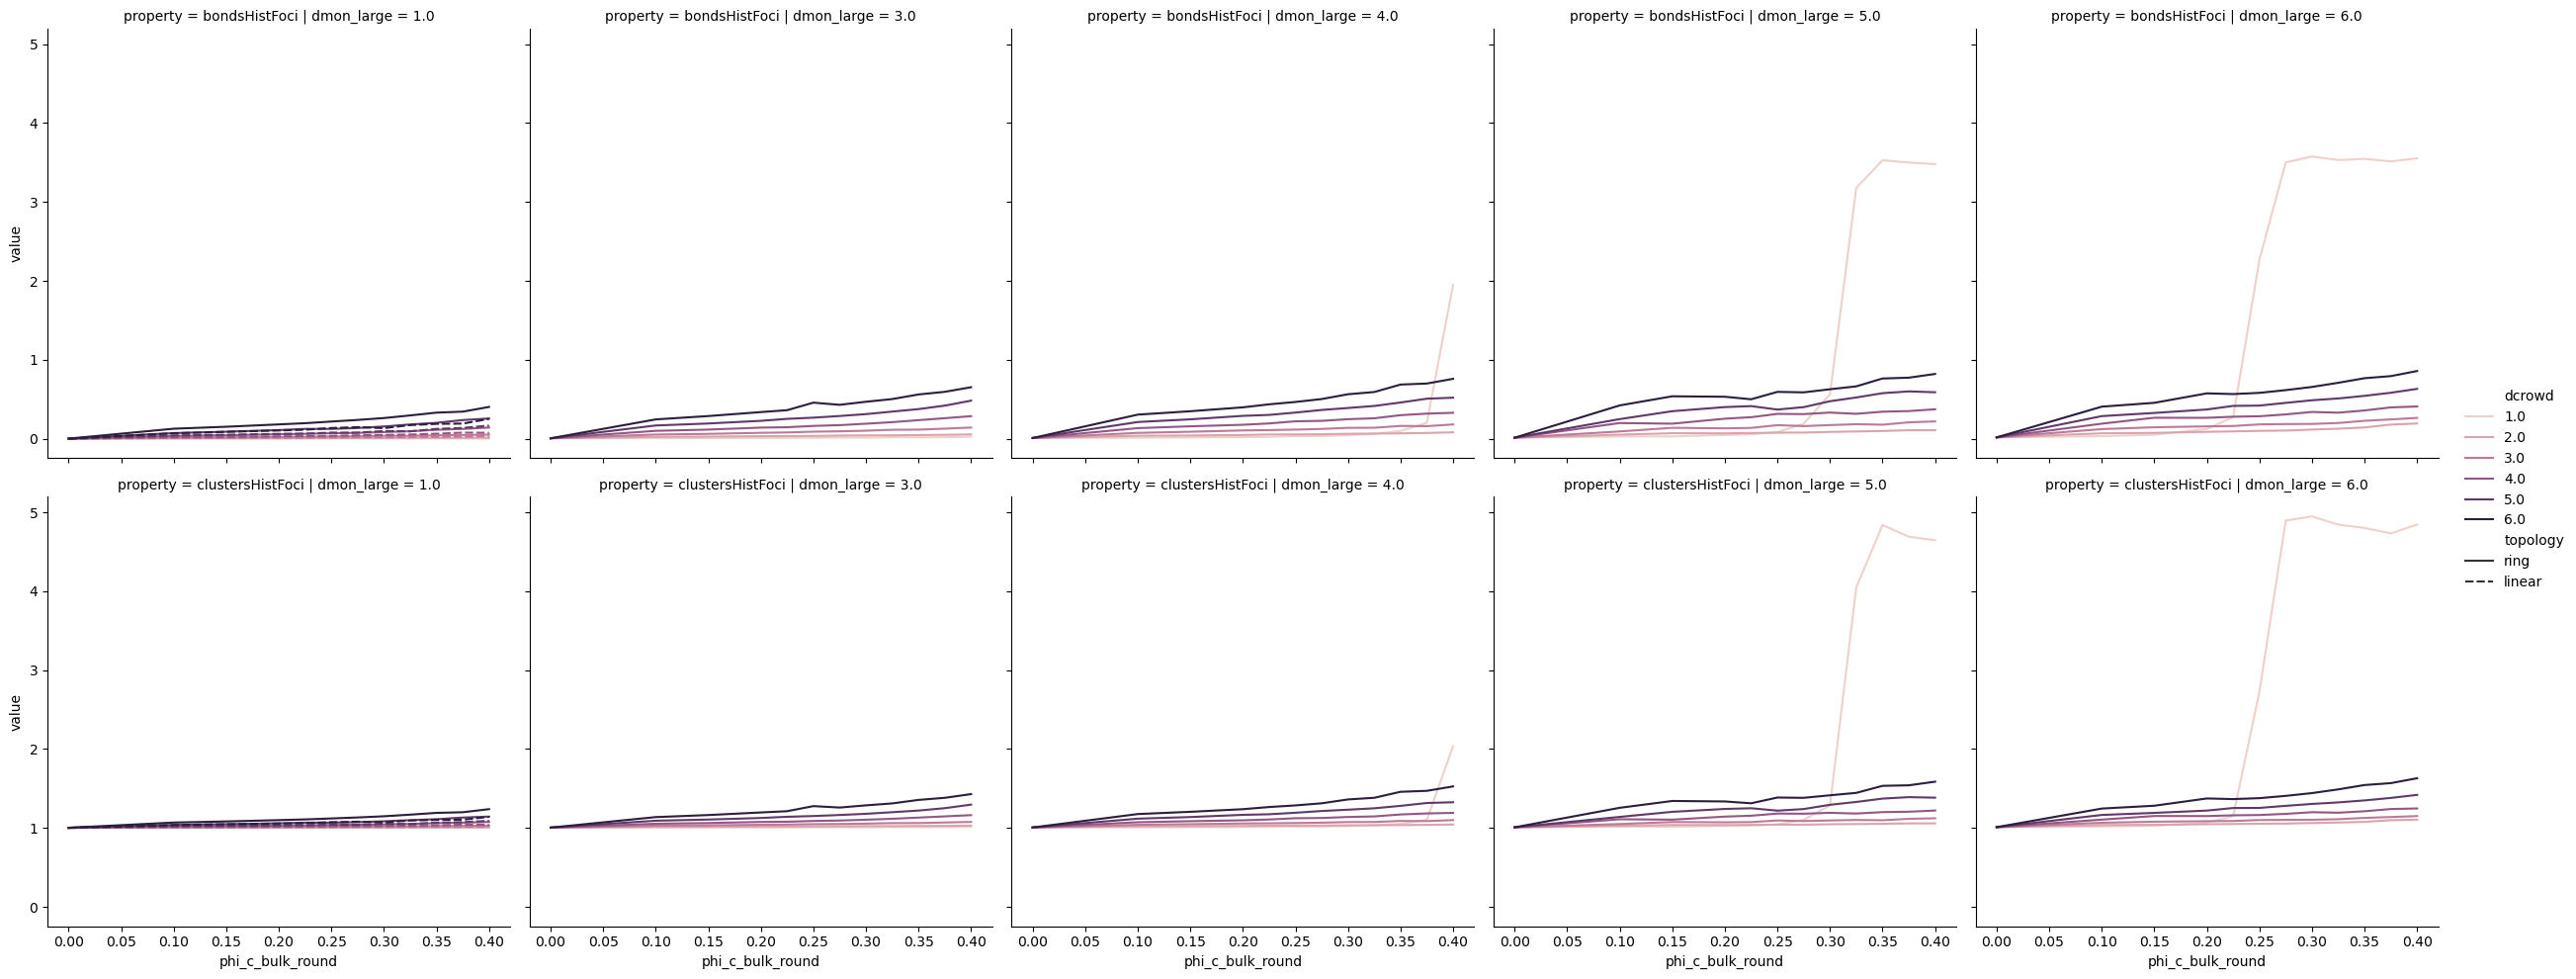

In [9]:
grid = sns.relplot(
    data=foci_weighted,
    x='phi_c_bulk_round',
    y='value',
    row='property',
    col='dmon_large',
    hue='dcrowd',
    style='topology',
    kind='line',
)
grid.figure.show()
plt.show()

## Local spatial distributions:

In [10]:
#project = 'TransFociCub'
#allInOne_dbs = ['/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/', '../../Datasets/'+project+'-allInOne/']
phase = 'ensAvg'
projects = ['SumRuleCubHeteroLinear', 'SumRuleCubHeteroRing', 'TransFociCub']
# distributions
directions = ['r']
props = ['Phi' , 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Foci', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']#, 'norm-bulk']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Big mon.', 'Small mon.', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
group = 'all'
geometry = 'cubic'
var_cols = []
dist = []
local_dist_all = []

for project in projects:
    allInOne_db = '../../../Datasets/'+project+'-allInOne/'
    # equilibirum properties
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps', phase]
    )
    equil_db = allInOne_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    # stamps
    equil_db = '-'.join(
        ['allInOne', project, 'stamps', phase]
    )
    equil_db = allInOne_db + equil_db + '.csv'
    stamps = pd.read_csv(equil_db) 
    stamps['runtime'] = stamps['bdump'] * (stamps ['n_frames'] - 1)
    stamps['n_frames-adump'] = (stamps['runtime'] / stamps['adump']) + 1
    for normalizing_method in normalizing_methods:
        dist_per_norm = []
        melting_dict = [
            species + '-' + normalizing_method for species in species_list
        ]
        melting_dict.append('Sum-sumrule_local')
        for direction, prop in dir_prop_pairs:
            prop_fullname = direction + prop
            equil_db = '-'.join(['allInOne', project, group, prop_fullname])
            equil_db += '-NormalizedScaled.parquet.brotli'
            equil_db = allInOne_db + equil_db
            local_dist = pd.read_parquet(equil_db)
            local_dist['topology'] = PD[project]['topology']
            local_dist['project'] = project
            # bulk profiles of crowders in the crowder-only region
            ensembles = local_dist['ensemble_long'].unique()
            local_dist['bulk_profile-crowder_only'] = 0.
            local_dist['bulk_profile'] = 0.
            local_dist['rho_c_bulk'] = 0.
            cond_bin_center = (local_dist['bin_center-norm']<=0.86) & (local_dist
                ['bin_center-norm']>=0.6)
            for ens in ensembles:
                n_frames = stamps.loc[stamps['ensemble_long']==ens,'n_frames-adump'].values[0]
                cond_ens = (local_dist['ensemble_long']==ens)
                conds = cond_bin_center & cond_ens
                phi_c_crowder_only = local_dist.loc[conds,prop_fullname+ 'Crd-mean'].mean()
                local_dist.loc[local_dist['ensemble_long']==ens,'rho_c_bulk'] = stamps.loc[stamps['ensemble_long']==ens,'rho_c_bulk'].values[0]
                local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile-crowder_only'] = phi_c_crowder_only / n_frames
                if prop == 'Phi':
                    bulk_profile = local_dist.loc[cond_ens,'phi_c_bulk_round'].values[0]
                else:
                    bulk_profile = local_dist.loc[cond_ens,'rho_c_bulk'].values[0]
                local_dist.loc[local_dist['ensemble_long']==ens,'bulk_profile'] = bulk_profile

            # Re-normalizing bin_center along r direction based on largest lcube
            # in ensemble with phi_c=0 in each space
            # Assuming TransFociCub returns an object with an lcube attribute
            local_dist['lcube'] = local_dist['ensemble_long'].apply(
                lambda x: TransFociCub(
                    x, 'ensemble_long', geometry, group, 'linear', ispath=False).lcube)

            grouped = local_dist.groupby(['phi_c_bulk_round', 'dmon_large', 'dcrowd'])
            lcyl_for_combinations = grouped['lcube'].first()

            # Extract lcube for phi_c_bulk_round == 0
            lcube_phi_c_0 = local_dist[local_dist['phi_c_bulk_round'] == 0].groupby(['dmon_large', 'dcrowd'])['lcube'].first()
            def calculate_correction_ratio(row):
                phi_c_0 = lcube_phi_c_0.get((row['dmon_large'], row['dcrowd']))
                return row['lcube'] / phi_c_0 if phi_c_0 else None
            local_dist['correction_ratio'] = local_dist.apply(calculate_correction_ratio, axis=1) 
            local_dist['bin_center-norm-corrected'] = local_dist[
                'bin_center-norm'] * local_dist['correction_ratio']
            local_dist['bin_center-norm-dmon_large'] = local_dist[
                'bin_center'] / local_dist['dmon_large']
            # Normalizing bin_center with gyr:
            gyr_grouped = local_dist.groupby(['dmon_large','dcrowd'])
            gyr_phi_c_0 = chainsize_equil[chainsize_equil['phi_c_bulk_round'] ==
                                        0].groupby(
                                            ['dmon_large', 'dcrowd'])['gyrMon-mean'].first()
            def calculate_correction_ratio(row):
                phi_c_0 = gyr_phi_c_0.get((row['dmon_large'], row['dcrowd']))
                return row['bin_center'] / phi_c_0 if phi_c_0 else None
            local_dist['bin_center-gyr_mean'] = local_dist.apply(calculate_correction_ratio, axis=1) 
             
            #local_dist['bin_center-gyr_mean'] = local_dist.apply(
            #    lambda row: row['bin_center'] / gyr_phi_c_0[['dmon_large','dcrowd']],
            #    axis=1)
            ensembles = local_dist['ensemble_long'].unique()

            #for ens in ensembles:
            #    ens_cond_eq = chainsize_equil['ensemble_long']== ens
            #    ens_cond = local_dist['ensemble_long']== ens
            #    gyr_mean = \
            ##        chainsize_equil.loc[ens_cond_eq, 'gyrMon-mean'].values[0]
            #    local_dist.loc[ens_cond, 'bin_center-gyr_mean'] = local_dist.loc[ens_cond, 'bin_center'] / gyr_mean
            # Dropping redundant columns
            cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
            local_dist.drop(columns=cols_to_drop, inplace=True)
            # Sumrule at local level
            local_dist[prop_fullname + 'Sum-sumrule_local'] = 0
            for species in species_list:
                local_dist[prop_fullname+'Sum-sumrule_local'] += \
                    local_dist[prop_fullname+species+'-scale']
            local_dist[prop_fullname+'Sum-sumrule_local'] = \
                (local_dist[prop_fullname+'Sum-sumrule_local'] /
                local_dist[prop_fullname+'Crd-normalizer'])
            # Melting based local distributions on species:
            attributes = PD[project]['equil_attributes'].copy()
            attributes += [
                'bin_center', 'bin_center-norm', 'bin_center-dcrowd',
                'bin_center-gyr_mean', 'bin_center-norm-dmon_large',
                'bin_center-norm-corrected', 'bulk_profile-crowder_only',
                'bulk_profile', 'topology', 'project'
            ]
            var_name = 'species'
            var_cols = [prop_fullname + col for col in melting_dict]
            sel_cols = attributes + var_cols
            local_dist_melted = local_dist[sel_cols].melt(
                id_vars=attributes,
                value_vars=var_cols,
                value_name=normalizing_method + '_' + var_name + '_value',
                var_name=var_name)
            # Renaming values
            local_dist_melted.loc[:, var_name] = \
                local_dist_melted.loc[:, var_name].apply(
                    lambda x: x.split('-')[0].split(prop_fullname)[-1]
                )
            local_dist_melted.loc[:, var_name] = \
                local_dist_melted.loc[:, var_name].apply(
                    lambda x: species_names_dict[x]
            )
            # Dropping distributions with phi_c=0
            local_dist_melted = \
                local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
            # Fixing near-end problem in crowder distributions
            cond = local_dist_melted['bin_center-norm'] <= 0.98
            local_dist_melted = local_dist_melted.loc[cond, :]
            # local_dist_melted
            local_dist_melted['direction'] = direction
            local_dist_melted['property'] = prop
            
            dist_per_norm.append(local_dist_melted)
        dist_per_norm = pd.concat(dist_per_norm, axis=0)
        dist_per_norm.reset_index(inplace=True, drop=True)
        dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'],
                        inplace=True)  
        dist.append(dist_per_norm)

dist = pd.concat(dist) # nan is due to the norming method: two different columns
dist.reset_index(inplace=True, drop=True)
spaces = dist[['nmon_small','nmon_large','dmon_large', 'dcrowd']].drop_duplicates().sort_values(by=['nmon_small','nmon_large', 'dmon_large', 'dcrowd']).values
project_titles = {}
for (nmon_small, nmon_large, dmon_large, dcrowd) in spaces:
    project_title_style = {
        'TransFociCub': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, a_M={dmon_large}, a_c={dcrowd}$",
        'SumRuleCubHeteroLinear': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, a_M={dmon_large}, a_c={dcrowd}$",
        'SumRuleCubHeteroCub': fr" $N_m={int(nmon_small)}, N_M={int(nmon_large)}, a_M={dmon_large}, a_c={dcrowd}$",
        }
    project_titles[project] = project_title_style[project]

del directions, props, dir_prop_pairs, species_list, normalizing_methods
del normalizing_method, melting_dict, species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, var_cols, prop
del direction, local_dist, local_dist_melted, var_name,  attributes, sel_cols


# Viz

### Equilibrium properties: Homogenous chain ($a_M=1$), $a_c$ as color, topology as style

In [41]:
# Set style
save_to = '../../../test_plots/'
ext = 'pdf'
font_family = 'serif'

plot_params = {
    'talk': {
    'height': 3.5,
    'aspect': 1,#6/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.05, 0.05),
    },
    'paper': {
    'height': 2,
    'aspect': 16/9,#6/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.48, -0.04),
    }
}

rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both',
    'xtick.direction': 'inout',
    'ytick.direction': 'inout'
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'ncol': 6,
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1.0,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.5, 'y': 1, 'ha': 'center'}

# Ticks for bonds and clusters
p_attrs = {
    'nmon_large': 5,
    'nmon_small': 400
}
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }

# Filter data
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci']
property_cond = (equi_props['property'].isin(property_order))
dmon_large_chosen = 1
dmon_large_cond = (equi_props['dmon_large']==dmon_large_chosen)
dcrowd_cond = (equi_props['dcrowd'].isin([3, 4, 5, 6]))
data = equi_props.loc[(property_cond & dmon_large_cond & dcrowd_cond)]
data.reset_index(inplace=True, drop=True)

# Input parameters
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dcrowd' # 
color_palette = 'flare' #PTM[:len(data[hue_attr])]
col_attr = 'topology'
col_order = sorted(data[col_attr].unique()) 
style_attr = 'dcrowd'
#style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())

# Apply style
sns.reset_defaults()
plot_context = 'paper'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=plot_params[plot_context]['font_scale'],
    rc=rc_params
)

# Produce plot
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    row=row_attr,
    col=col_attr,
    row_order=row_order,
    #col_order=col_order,
    hue=hue_attr,
    style=style_attr,
    dashes=False,
    markers=True,
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.8,
    )

# Set titles, labels, ticks
grid.set_titles("")
grid.set_xlabels(AL[x_prop])
for irow in range(len(row_order)):
    for icol in range(len(col_order)):
        ax = grid.axes[irow, icol]
        ax.set_xlabel(AL[x_prop])
        if irow == 0 :
            ax.set_title(f"Homoegenous {col_order[icol]} polymer ($a_M={dmon_large_chosen}$)")
            ax.set_ylabel(AL['gyrMon-norm'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_yticks(np.arange(0,1.2,0.2))
            ax.set_ylim(-0.05,1.05)
        elif irow == 1:
            ax.set_ylabel(AL['bondsHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['bondsHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.5,4.5)
        else:
            ax.set_ylabel(AL['clustersHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['clustersHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(0.5,5.5)
# Set legends
handles, labels = grid.axes[0,0].get_legend_handles_labels()
color_labels = [rf'$a_c={float(label)}$' for label in labels]
sns.move_legend(
    grid,
    labels=color_labels,
    title=None,
    loc='lower center',
    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    **legend_kws
)
# Save plot

grid.tight_layout(w_pad=0.2, h_pad=0.2)
output = "-".join(
    ["Equilibrium_properties-dcrowd_as_hue-toplogy_as_style", plot_context]
    )
grid.figure.align_ylabels()
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

In [35]:
grid.col_names

['linear', 'ring']

### Equilibrium properties: Quantities as rows, $a_c$ as cols, $a_l$ as hue: 
#### Not good chain properties, including size, should be the same across systems, to make comparsion more (apple should be compared with apple)

In [12]:
# Set style
save_to = '../../../test_plots/'
ext = 'pdf'
font_family = 'serif'

plot_params = {
    'talk': {
    'height': 3.5,
    'aspect': 1,#6/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.05, 0.05),
    },
    'paper': {
    'height': 2,
    'aspect': 1,#6/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.48, -0.04),
    }
}

rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both',
    'xtick.direction': 'inout',
    'ytick.direction': 'inout'
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'ncol': 2,
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.5, 'y': 1, 'ha': 'center'}


# Ticks for bonds and clusters
p_attrs = {
    'nmon_large': 5,
    'nmon_small': 400
}
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }

# Filter data
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci',]
property_cond = (equi_props['property'].isin(property_order))
topology_cond = (equi_props['topology']=='ring')
data = equi_props.loc[(property_cond & topology_cond)]
data.reset_index(inplace=True, drop=True)

# Input parameters
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dmon_large'
color_palette = 'flare' # PTM[:len(data[hue_attr])]
col_attr = 'dcrowd'
col_order = sorted(data[col_attr].unique()) 
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())

# Aplly style
sns.reset_defaults()
plot_context = 'paper'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=plot_params[plot_context]['font_scale'],
    rc=rc_params
)

# Produce plot
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    row=row_attr,
    col=col_attr,
    row_order=row_order,
    col_order=col_order,
    hue=hue_attr,
    style=hue_attr,
    dashes=False,
    markers=True,
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.8,
    #lw=2
    )
grid.set_titles("")

# Set titles and labels
grid.set_xlabels(AL[x_prop])
for irow in range(len(row_order)):
    for icol in range(len(col_order)):
        ax = grid.axes[irow,icol]
        ax.set_xlabel(AL[x_prop])
        if irow == 0 :
            ax.set_title(fr"$a_c={col_order[icol]}$", **fig_title_kws)
            ax.set_ylabel(AL['gyrMon-norm'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.05,1.05)
        elif irow == 1:
            ax.set_ylabel(AL['bondsHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['bondsHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.5,4.5)
        else:
            ax.set_ylabel(AL['clustersHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['clustersHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(0.5,5.5)
# Set legends
handles, labels = grid.axes[0,0].get_legend_handles_labels()
color_labels = [rf'$a_M={float(label)}$' for label in labels]
sns.move_legend(
    grid,
    labels=color_labels,
    title=None,
    loc='lower center',
    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    ncol=6
)
# Save plot
grid.tight_layout(w_pad=0.2, h_pad=0.2)
output = "-".join(
    ["Equilibrium_properties", "dcrowd_as_hue", "dmon_large_col", plot_context]
    )
grid.figure.align_ylabels()
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

### Equilibrium properties: Quantities as rows, $a_l$ as cols, $a_c$ as hue

In [20]:
# Set style
save_to = '../../../test_plots/'
ext = 'pdf'
font_family = 'serif'

plot_params = {
    'talk': {
    'height': 3.5,
    'aspect': 1,#6/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.05, 0.05),
    },
    'paper': {
    'height': 2,
    'aspect': 1,#6/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.48, -0.04),
    }
}

rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both',
    'xtick.direction': 'inout',
    'ytick.direction': 'inout'
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'ncol': 2,
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    #'markerscale': 0.5
}
fig_title_kws = {'x': 0.5, 'y': 1, 'ha': 'center'}

# Ticks for bonds and clusters
p_attrs = {
    'nmon_large': 5,
    'nmon_small': 400
}
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }

# Filter data
property_order = ['gyrMon-norm', 'bondsHistFoci', 'clustersHistFoci']
property_cond = (equi_props['property'].isin(property_order))
topology_cond = (equi_props['topology']=='ring')
data = equi_props.loc[(property_cond & topology_cond)]
data.reset_index(inplace=True, drop=True)

# Input parameters
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'dcrowd' # 
color_palette = 'flare' #PTM[:len(data[hue_attr])]
col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique()) 
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())

# Apply style
sns.reset_defaults()
plot_context = 'paper'
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=plot_params[plot_context]['font_scale'],
    rc=rc_params
)

# Produce plot
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    row=row_attr,
    col=col_attr,
    row_order=row_order,
    col_order=col_order,
    hue=hue_attr,
    style=hue_attr,
    dashes=False,
    markers=True,
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    alpha=0.8,
    )

# Set titles, labels, ticks
grid.set_titles("")
grid.set_xlabels(AL[x_prop])
for irow in range(len(row_order)):
    #for icol in range(len(col_order)):
    for icol, letter in enumerate("ABCDE"):
        ax = grid.axes[irow,icol]
        ax.set_xlabel(AL[x_prop])
        if irow == 0 :
            ax.set_title(fr"{letter}) $a_M={col_order[icol]}$", **fig_title_kws)
            ax.set_ylabel(AL['gyrMon-norm'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_yticks(np.arange(0,1.2,0.2))
            ax.set_ylim(-0.05,1.05)
        elif irow == 1:
            ax.set_ylabel(AL['bondsHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['bondsHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(-0.5,4.5)
        else:
            ax.set_ylabel(AL['clustersHistFoci-bin_center-average'])
            ax.set_yticks(prop_ticks['clustersHistFoci'])
            ax.set_xticks(np.arange(0,0.5,0.1))
            ax.set_ylim(0.5,5.5)
# Set legends
handles, labels = grid.axes[0,0].get_legend_handles_labels()
color_labels = [rf'$a_c={float(label)}$' for label in labels]
sns.move_legend(
    grid,
    labels=color_labels,
    title=None,
    loc='lower center',
    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    ncol=6
)
# Save plot

grid.tight_layout(w_pad=0.2, h_pad=0.2)
output = "-".join(
    ["Equilibrium_properties", "dmon_large_col", "dcrowd_as_hue", plot_context]
    )
grid.figure.align_ylabels()
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()

### Why do larger crowders seem better in chain compaction:

In [16]:
nu = 0.588
c_flory = 1.12
c_rog = 1.18
n_mon = 100
r_flory = c_flory * n_mon**nu
print(f"Flory's radius: {round(r_flory, 3)}")
rog = c_rog * n_mon**nu 
print(f"Radius of gyration: {round(rog, 3)}")

Flory's radius: 16.796
Radius of gyration: 17.696


### Spatial distribution: normalized by gyr

In [ ]:
rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': False,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'both'
    }

In [35]:
# Set style
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'serif'

plot_params = {
    'talk': {
    'height': 3.5,
    'aspect': 1,#6/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.05, 0.05),
    },
    'paper': {
    'height': 2,
    'aspect': 1,#6/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.48, -0.04),
    }
}

rc_params = {
    'axes.facecolor': 'white',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'xtick.direction': 'inout',
    'ytick.direction': 'inout'
}

facet_kws = {'sharey': True, 'sharex': False, 'legend_out': True}
legend_kws = {
    'ncol': 1,
    #'bbox_to_anchor': (0.78, 0.92),
    'bbox_to_anchor': (0.85, 0.93), # Paper
    #'bbox_to_anchor': (0.6, 0.9), # talk
    'frameon': False,
    'facecolor': 'white',
    'borderpad': 0.1,
    'ncols': 1,
    'markerscale': 1.,
}


fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}

height = 2.5
aspect = 1#0.9*16/8
plot_context = 'paper'


# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}

# Filter data
direction = 'r'
dir_cond = (dist['direction'].isin([direction]))
bin_center_max = 0.93
bin_center_cond = (dist['bin_center-norm'] <= bin_center_max) 
property_ = 'Phi'
prop_cond = (dist['property'].isin([property_]))
phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
species_cond = (dist['species'].isin(['Crowders', 'Small mon.', 'Big mon.']))
dmon_large_chosen = 6.0
dmon_large_cond = (dist['dmon_large'].isin([dmon_large_chosen]))
dcrowd_cond = (dist['dcrowd'].isin([dmon_large_chosen]))
x_prop = 'bin_center-gyr_mean'
#r_gyr_cut  = 
#bin_center_cond = (dist[x_prop]<=r_gyr_cut)
cond = dir_cond & prop_cond & bin_center_cond & species_cond & phi_cond & dmon_large_cond #
data = dist.loc[cond, :].copy()
data.reset_index(inplace=True, drop=True)

# Set paramters

x_prop_name = x_prop + '-' + direction + '-cub'

y_prop = 'norm_species_value'

col_attr = 'dcrowd'
col_order = sorted(data[col_attr].unique())

row_attr = 'species'
row_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

style_attr = 'species'
style_order = ['Crowders', 'Small mon.', 'Big mon.']#, 'Sum']

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = sns.color_palette("rocket_r", len(hue_order))

sns.set_theme(
        context=plot_context,
        style='ticks',
        palette=color_palette,
        font='Times New Roman',
        font_scale=plot_params[plot_context]['font_scale'],
        rc=rc_params
    )
if direction == 'r':
    markevery = 5
else:
    markevery = 15
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    #markers=True,
    #dashes=False,
    kind='line',
    height=height,
    aspect=aspect,
    legend='full',
    palette=color_palette,
    facet_kws=facet_kws,
    #markersize=20,
    #markevery=markevery,
    alpha=0.8,
    #lw=1.5,
    )
grid.set_titles(AL['dmon_large'] + f"$={dmon_large_chosen}$, " + AL[col_attr] + r"$={col_name}$")
grid.set_xlabels(AL[x_prop_name])

legend_labels = list(hue_order)
for idx, new_label in enumerate(legend_labels):
    grid._legend.legend_handles[idx].set_linewidth(2)
for i, species in enumerate(row_order):
    for j in range(len(col_order)):
        grid.axes[i,j].set_ylabel(
            AL[direction+property_+'-norm-'+species_shortnames[species]]
        )
        grid.axes[i,j].set_xlabel(AL[x_prop_name])
        grid.axes[i,j].set_ylim(-0.05,1.05)
        grid.axes[i,j].set_xticks(np.arange(0,4.0,1))
        grid.axes[i,j].set_xlim(-0.05,3.5)
handlers, labels = grid.axes[0,0].get_legend_handles_labels() 

color_labels = [rf'$\phi_c={float(label)}$' for label in labels]
sns.move_legend(
    grid,
    labels=color_labels,
    title=None,
    loc='lower center',
    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    ncol=4
)
output = "-".join(
    ["equilPlot", project, direction + property_, f'NormalizedScaled-speciesPerRow-dcrowdPerCol-dmon_large{dmon_large_chosen}-gyr_mean', plot_context]
)
grid.tight_layout(w_pad=0, h_pad=0.5)
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
plt.close()



### Sum Rule alone: all $a_l$ and $a_c$

In [41]:
# Filtering dataset
species_shortnames = {
    'Crowders': 'Crd',
    'Small mon.': 'Mon',
    'Big mon.': 'Foci',
    'Sum': 'Sum'
}
for direction in ['r']:
    for property_ in ['Phi', 'Rho']:
        species_cond = (dist['species'].isin(['Sum']))
        phi_cond = (dist['phi_c_bulk_round'].isin([0.1 ,0.2, 0.225, 0.250, 0.275, 0.3, 0.4]))
        bin_center_max = 0.93
        bin_center_cond = (dist['bin_center-norm'] <= bin_center_max)
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        #dcrowd_chosen = 1.0
        #dcrowd_cond = (dist['dcrowd'].isin([dcrowd_chosen]))
        cond = dir_cond & prop_cond & bin_center_cond & species_cond & phi_cond
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = './'

        x_prop = 'bin_center-gyr_mean'
        if direction == 'r':
            x_prop_name = x_prop + '-' + direction + '-cub'
        else:
            x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'dmon_large'
        row_attr = 'dcrowd'

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'  
        height = 4.25
        aspect = 1 #.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'white',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            'xtick.direction': 'inout',
            'ytick.direction': 'inout'
        }
        save_to = '../../test_plots/'
        font_scale = 1
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.9, 0.95),# (0.63, 0.45),# (0.8, 0.93),
            'frameon': False,
            'facecolor': 'white',
            'borderpad': 0.1,
            'ncol': 1,
            'markerscale': 2,
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        if direction == 'r':
            markevery = 5
        else:
            markevery = 15
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            row=row_attr,
            hue=hue_attr,
            hue_order=hue_order,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            alpha=0.9,
            lw=1.5,
            )
        grid.set_titles(AL[col_attr] + r"$={col_name}$, " + AL[row_attr] + r"$={row_name}$")
        grid.set_ylabels(AL[direction+property_+'-norm'])
        grid.map(plt.axhline, y=1.0, xmin=0.0,xmax=2.3,
                 color='darkgreen', lw=1.5,
                 label=AL[direction+property_+'-norm-Sum_constant'])

        #for idx, new_label in enumerate(handles):
        #    grid._legend.legend_handles[idx].set_linewidth(2)
        #grid._legend.set_title(AL[hue_attr])
        sum_rule_handler = tuner.ls_handler([AL[direction+property_+'-norm-Sum_constant-cub']],
            ['-'],color='darkgreen',lw=2)
        for ax in grid.axes.flatten():
            ax.set_ylabel(AL[direction+property_+'-norm'])
            ax.set_xlabel(AL[x_prop_name])
            ax.set_ylim(0.45,2.75)
            ax.set_xlim(0,2.3)
            ax.legend(handles=sum_rule_handler,labels=[AL[direction + property_ + '-norm-Sum_constant-cub']], loc='lower right', frameon=False) 
        
            
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-dcrowdPerCol-SumRuleAlone']
        )
        grid.tight_layout(w_pad=0.5, h_pad=0.5)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

## Logs

In [6]:
log_df = pd.read_csv("/Users/amirhsi/research_data/SumRuleCubHetero-allInOne/allInOne-TransFociCub-logs-runtime_summary.csv")
print(log_df.head())

                                            log_name  wall_time_sec  \
0  al1nl5ml1ns400ac2nc17404l45dt0.005bdump2000adu...          44341   
1  al1nl5ml1ns400ac2nc17404l45dt0.005bdump2000adu...          45501   
2  al1nl5ml1ns400ac2nc17404l45dt0.005bdump2000adu...          44710   
3  al1nl5ml1ns400ac2nc17404l45dt0.005bdump2000adu...          42820   
4  al1nl5ml1ns400ac2nc26106l45dt0.005bdump2000adu...          62915   

   wall_time_hr  n_cores  n_atoms  avg_step_per_sec bin_scheme  rskin  
0       12.3169        8    17809           2325.99      multi    0.3  
1       12.6392        8    17809           2268.55      multi    0.3  
2       12.4194        8    17809           2307.47      multi    0.3  
3       11.8944        8    17809           2414.40      multi    0.3  
4       17.4764        8    26511           1638.37      multi    0.3  


In [15]:
x_prop = 'n_atoms'
y_prop = 'wall_time_hr'
hue_attr = 'n_cores'
color_palette = AC[:len(hue_order)]
plot_context = 'paper'
sns.reset_defaults()
fig, ax = plt.subplots()
#height = plot_params[plot_context]['height']
#aspect = plot_params[plot_context]['aspect']
grid = sns.relplot(
    ax=ax,
    data=log_df,
    x=x_prop,
    y=y_prop,
    col=hue_attr,
    kind='line',
    legend='full',
    marker='s',
    palette=color_palette,
    facet_kws={'sharey': False, 'sharex': False}
)
output = "-".join(
    ["Wall_time_stats", "n_atoms",
        "n_cores", plot_context])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
